In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from AbundanceMatching import *
import numpy as np
import Corrfunc
from Corrfunc.theory import wp
from scipy.stats import multivariate_normal
from galaxy_statistics import generate_wp,comp_deconv_steps,AMLikelihood
from astropy.io import fits
import matplotlib
custom_blues = ["#66CCFF", "#33BBFF", "#00AAFF", "#0088CC", "#006699", "#004466"]
custom_blues_complement = ["#FF9966", "#FF7733", "#FF5500", "#CC4400", "#993300",
 "#662200"]

In [2]:
data_path = '/u/ki/rmredd/data/'

# Pick the magnitude 20 limited luminosity function for now. Would use 21 but there isn't one
lf_20 = np.loadtxt(data_path + 'lf/tinker/lf_jt_20.dat')

# Remove any entries that are 0 since they cause problems with the abundance matching code
lf_20 = lf_20[lf_20[:,1]>0,:]

# Load the 2d projected correlation function and the covariance matrix
wp_path = '/u/ki/rmredd/data/corr_wp/tinker_sdss_wp/'
mag_cut = -21
wp_21 = np.loadtxt(wp_path + 'wp_21.dat')
wp_21_cov_temp = np.loadtxt(wp_path + 'wp_covar_21.dat')

# Convert the covariance file into a matrix format for analysis
wp_21_cov = np.zeros((len(wp_21),len(wp_21)))
for wp_tup in wp_21_cov_temp:
    wp_21_cov[int(wp_tup[0])-1,int(wp_tup[1])-1] = wp_tup[2]
    wp_21_cov[int(wp_tup[1])-1,int(wp_tup[0])-1] = wp_tup[2]
    
# Drop the 2d projected correlation function data that's outside what our box is sensitive to
r_cutoff = 15
wp_21_cov=wp_21_cov[wp_21[:,0]<r_cutoff,:]
wp_21_cov=wp_21_cov[:,wp_21[:,0]<r_cutoff]
wp_21_var = np.diag(wp_21_cov)
wp_21 = wp_21[wp_21[:,0]<r_cutoff]

# Set a few of the analysis parameters (box size, the pimax and nthreads for w2p calculation, and the number of
# deconv steps used in removing the scatter from the luminosity function)
box_size = 400
pimax = 40.0
nthreads = 1
deconv_repeat = 200

# Pull the halos from the box
halo_path = '/nfs/slac/des/fs1/g/sims/jderose/BCCSims/c400-2048/'
halos = np.array(fits.open(halo_path + 'hlist_1.00000.list.fits')[1].data)

# Generate the bins that will be used for the w2p calculation (chosen to roughly match the points used for
# wp_18, but the exact bins would be better).
r_p_data = wp_21[:,0]
rbins = np.zeros(len(r_p_data)+1)
rbins[1:-1] = 0.5*(r_p_data[:-1]+r_p_data[1:])
rbins[0] = 2*r_p_data[0]-rbins[1]
rbins[-1] = 2*r_p_data[-1]-rbins[-2]

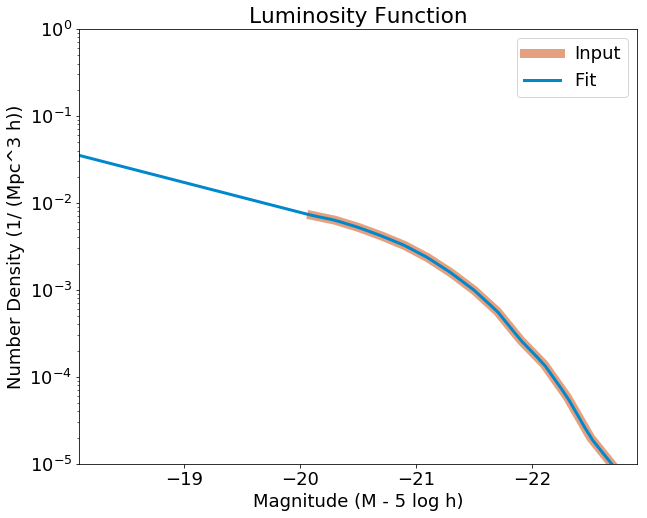

In [3]:
# Get the abundance matching function (Yao's code) to fit the LF
af = AbundanceFunction(lf_20[:,0], lf_20[:,1], (-25, -5))

# Make a plot to check that af has a reasonable fit to the data
# Plotting details
matplotlib.rcParams.update({'font.size': 18}); plt.figure(figsize=(10,8))
plt.xlim([np.max(lf_20[:,0])+2,np.min(lf_20[:,0])]); plt.ylim([1e-5,1])
plt.xlabel('Magnitude (M - 5 log h)'); plt.ylabel('Number Density (1/ (Mpc^3 h))')
plt.title('Luminosity Function');plt.yscale('log')

# What I actually want to plot
plt.plot(lf_20[:,0], lf_20[:,1],lw=9,alpha=0.5,c=custom_blues_complement[3])
x = np.linspace(np.min(lf_20[:,0])-2, np.max(lf_20[:,0])+2, 101)
plt.semilogy(x, af(x),lw=3,c=custom_blues[3])
plt.legend(['Input','Fit']); plt.show()

In [4]:
# Now we get the number density of the halos based on the matching property v_max
nd_halos = calc_number_densities(halos['vmax'], box_size)

# Add scatter to our abundance matching prescription
scatter = 0.2
af.deconvolute(scatter*LF_SCATTER_MULT,deconv_repeat)

# Match using the scatter I've chosen
catalog_scatter = af.match(nd_halos,scatter*LF_SCATTER_MULT,do_rematch=True)
catalog_scatter_ns = af.match(nd_halos,scatter*LF_SCATTER_MULT,do_add_scatter=False,do_rematch=True)

# Match without scatter
catalog = af.match(nd_halos)

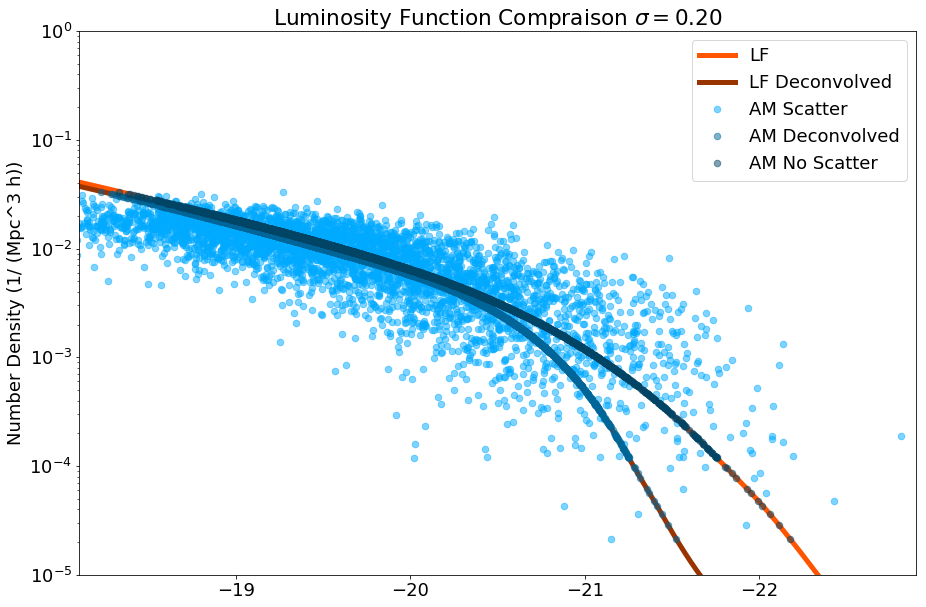

In [5]:
# Compare the generated catalogs by plotting them on the number density v lum. curves
sub_samp = 4000

# Plotting details
plt.figure(figsize=(15,10))
plt.xlim([np.max(lf_20[:,0])+2,np.min(lf_20[:,0])]); plt.ylim([1e-5,1])
plt.ylabel('Number Density (1/ (Mpc^3 h))'); 
plt.title('Luminosity Function Compraison $\sigma = $%.2f'%(scatter));plt.yscale('log')

# What I'm actually interested in plotting
# Plot the lf before and after deconvolution
x, nd = af.get_number_density_table()
plt.plot(x,nd,c=custom_blues_complement[2],lw=5)
plt.plot(af._x_deconv[float(scatter*LF_SCATTER_MULT)],nd,c=custom_blues_complement[4],lw=5)

# Plot the luminosity assigned with and without scatter as a function of halo number density
plt.plot(catalog_scatter[:sub_samp],nd_halos[:sub_samp],'.',c=custom_blues[2],markersize=13,alpha=0.5)
plt.plot(catalog_scatter_ns[:sub_samp],nd_halos[:sub_samp],'.',c=custom_blues[4],markersize=13,alpha=0.5)
plt.plot(catalog[:sub_samp],nd_halos[:sub_samp],'.',c=custom_blues[5],markersize=13,alpha=0.5)

plt.legend(['LF','LF Deconvolved','AM Scatter','AM Deconvolved','AM No Scatter'])
plt.show()

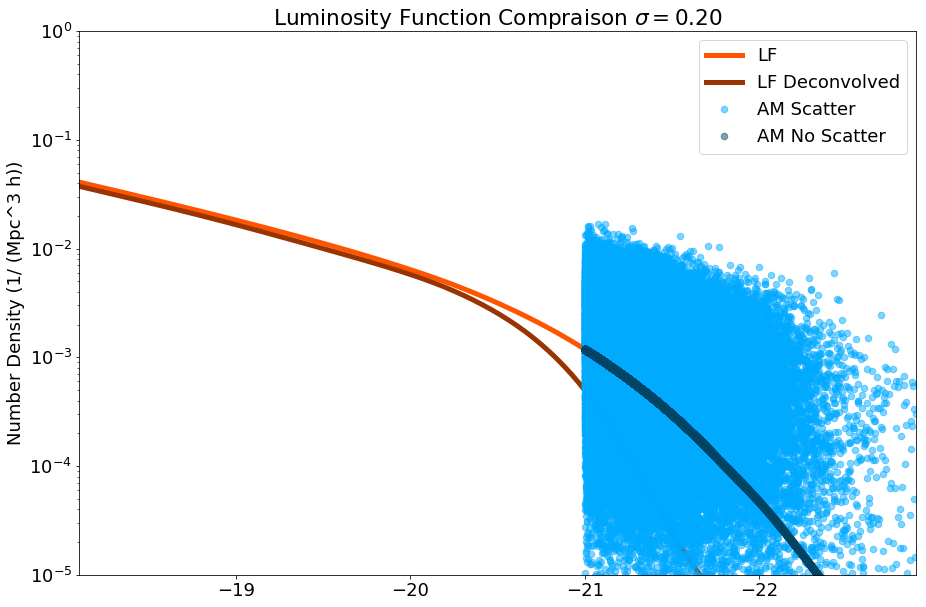

No Scatter has 76063 galaxes
0.20 Scatter has 76063 galaxes


In [6]:
# Mag cut 
# Pull part of catalog that is above the magnitude cut we're interested in
sub_catalog = catalog<=mag_cut
sub_catalog_scatter = catalog_scatter<=mag_cut

# Confirm that we've cut as intended
plt.figure(figsize=(15,10))
plt.xlim([np.max(lf_20[:,0])+2,np.min(lf_20[:,0])]); plt.ylim([1e-5,1]); plt.ylabel('Number Density (1/ (Mpc^3 h))'); 
plt.title('Luminosity Function Compraison $\sigma = $%.2f'%(scatter));plt.yscale('log')
x, nd = af.get_number_density_table()
plt.plot(x,nd,c=custom_blues_complement[2],lw=5)
plt.plot(af._x_deconv[float(scatter*LF_SCATTER_MULT)],nd,c=custom_blues_complement[4],lw=5)
plt.plot(catalog_scatter[sub_catalog_scatter],nd_halos[sub_catalog_scatter],'.',c=custom_blues[2],markersize=13,
        alpha=0.5)
plt.plot(catalog[sub_catalog],nd_halos[sub_catalog],'.',c=custom_blues[5],markersize=13,alpha=0.5)

plt.legend(['LF','LF Deconvolved','AM Scatter','AM No Scatter'])
plt.show()

print("No Scatter has %d galaxes"%(np.sum(sub_catalog)))
print("%.2f Scatter has %d galaxes"%(scatter,np.sum(sub_catalog_scatter)))

In [7]:
# Do the w2p calculation
# Firt extract the positions of the galaxies given the two catalogs
x = halos['px'][sub_catalog]
y = halos['py'][sub_catalog]
z = halos['pz'][sub_catalog]

x_scatt = halos['px'][sub_catalog_scatter]
y_scatt = halos['py'][sub_catalog_scatter]
z_scatt = halos['pz'][sub_catalog_scatter]

# Calculate the projected two point correlation function in both cases
wp_results = wp(box_size, pimax, nthreads, rbins, x, y, z, verbose=True, 
    output_rpavg=True)
wp_results_scatter = wp(box_size, pimax, nthreads, rbins, x_scatt, y_scatt, z_scatt, verbose=True, 
    output_rpavg=True)

# Extract the actual results
wp_binned = np.zeros(len(wp_results))
for i in range(len(wp_results)):
    wp_binned[i] = wp_results[i][3]
    
wp_binned_scatter = np.zeros(len(wp_results_scatter))
for i in range(len(wp_results_scatter)):
    wp_binned_scatter[i] = wp_results_scatter[i][3]


/u/ki/swagnerc/.local/lib/python3.7/site-packages/Corrfunc-2.3.1-py3.7-linux-x86_64.egg/Corrfunc/utils.py:916: UserWarning: One or more input array has non-native endianness!  A copy will be made with the correct endianness.
  warnings.warn("One or more input array has non-native endianness!  A copy will"\
In gridlink_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,27,10.  Time taken =   0.015 sec
Using fallback kernel
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.146 secs
In gridlink_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,27,10.  Time taken =   0.011 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.143 secs


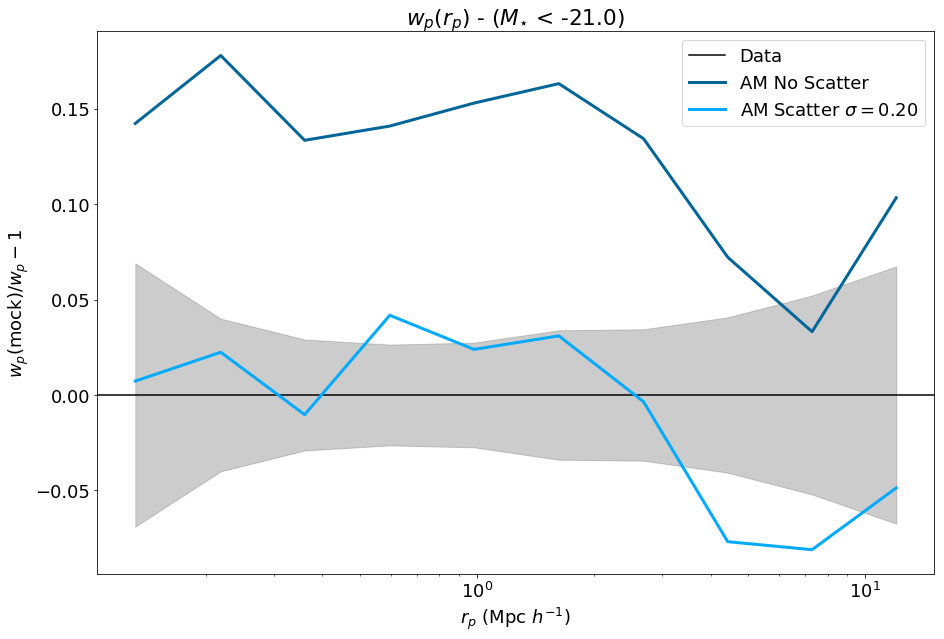

In [8]:
# Now compare the generated projected two point correlation functions to what was measured in the data

# Plotting details
plt.figure(figsize=(15,10)); plt.title('$w_p(r_p)$ - ($M_{\star}$ < %.1f)'%(-21.0))
plt.ylabel('$w_p (\mathrm{mock}) / w_p - 1$'); plt.xlabel('$r_p \ (\mathrm{Mpc } \ h^{-1})$')
plt.xscale('log'); plt.axhline(0,c='k')

# What I actually want to plot
plt.plot(wp_21[:,0],wp_binned/wp_21[:,1]-1,lw=3,c=custom_blues[4])
plt.plot(wp_21[:,0],wp_binned_scatter/wp_21[:,1]-1,lw=3,c=custom_blues[2])
plt.fill_between(wp_21[:,0],-np.sqrt(wp_21_var)/wp_21[:,1],np.sqrt(wp_21_var)/wp_21[:,1],alpha=0.4,color='grey')
plt.legend(['Data','AM No Scatter','AM Scatter $\sigma = %.2f$'%(scatter)])

plt.show()

In [28]:
x = halos['px'][:10000]
y = halos['py'][:10000]
z = halos['pz'][:10000]
wp_results = wp(400, 40.0, 1, rbins, x, y, z, verbose=True, output_rpavg=True)

In gridlink_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,27,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.166 secs
